# Flutter Analysis of a Goland Wing using the SHARPy Linear Solver

This is an example using SHARPy to find the flutter speed of a Goland wing by:

* Calculating aerodynamic forces and deflections using a nonlinear solver

* Linearising about this reference condition

* Creating a reduced order model of the linearised aerodynamics

* Evaluate the stability of the linearised aeroelastic system at different velocities



#### References

Maraniello, S., & Palacios, R. (2019). State-Space Realizations and Internal Balancing in Potential-Flow Aerodynamics with Arbitrary Kinematics. AIAA Journal, 57(6), 1–14. https://doi.org/10.2514/1.J058153



## Required Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import sharpy.cases.templates.flying_wings as wings  # See this package for the Goland wing structural and aerodynamic definition
import sharpy.sharpy_main  # used to run SHARPy from Jupyter

## Problem Set-up

### Velocity

The UVLM is assembled in normalised time at a velocity of $1 m/s$. The only matrices that need updating then with free stream velocity are the structural matrices, which is significantly cheaper to do than to update the UVLM.

In [6]:
u_inf = 1.
alpha_deg = 0.
rho = 0.1
num_modes = 6

### Discretisation

Note: To achieve convergence of the flutter results with the ones found in the literature, a significant discretisation may be required. If you are running this notebook for the first time, set `M = 4` initially to verify that your system can perform!

In [7]:
M = 16
N = 32
M_star_fact = 10

### ROM

A moment-matching (Krylov subspace) model order reduction technique is employed. This ROM method offers the ability to interpolate the transfer functions at a desired point in the complex plane. See the ROM documentation pages for more info.

Note: this ROM method matches the transfer function but does not guarantee stability. Therefore the resulting system may be unstable. These unstable modes may appear far in the right hand plane but will not affect the flutter speed calculations.

In [8]:
c_ref = 1 # Goland wing reference chord. Used for frequency normalisation
rom_settings = dict()
rom_settings['algorithm'] = 'mimo_rational_arnoldi'  # reduction algorithm
rom_settings['r'] = 6  # Krylov subspace order
frequency_continuous_k = np.array([0.])  # Interpolation point in the complex plane with reduced frequency units
frequency_continuous_w = 2 * u_inf * frequency_continuous_k / c_ref
rom_settings['frequency'] = frequency_continuous_w

### Case Admin

In [9]:
case_name = 'flyingWing'
case_nlin_info = 'M%dN%dMs%d_nmodes%d' % (M, N, M_star_fact, num_modes)
case_rom_info = 'rom_MIMORA_r%d_sig%04d_%04dj' % (rom_settings['r'], frequency_continuous_k[-1].real * 100,
                                                  frequency_continuous_k[-1].imag * 100)

case_name += case_nlin_info + case_rom_info

route_test_dir = os.path.abspath('')

print('The case to run will be: %s' % case_name)
print('Case files will be saved in ./cases/%s' %case_name)
print('Output files will be saved in ./output/%s/' %case_name)

The case to run will be: flyingWingM16N32Ms10_nmodes6rom_MIMORA_r6_sig0000_0000j
Case files will be saved in ./cases/flyingWingM16N32Ms10_nmodes6rom_MIMORA_r6_sig0000_0000j
Output files will be saved in ./output/flyingWingM16N32Ms10_nmodes6rom_MIMORA_r6_sig0000_0000j/


## Simulation Set-Up

### Goland Wing

`ws` is an instance of a Goland wing with a control surface. Reference the template file `sharpy.cases.templates.flying_wings.GolandControlSurface` for more info on the geometrical, structural and aerodynamic definition of the Goland wing here used.

In [10]:
ws = wings.Smith(M=M,
                 N=N,
                 Mstar_fact=M_star_fact,
                 u_inf=u_inf,
                 alpha=alpha_deg)


ws.clean_test_files()
ws.update_derived_params()
ws.set_default_config_dict()
ws.generate_aero_file()
ws.generate_fem_file()
print(ws.stiffness[0])

[[1.0e+07 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 1.0e+06 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 1.0e+06 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 3.0e+05 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 6.0e+05 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.5e+08]]


### Simulation Settings

The settings for each of the solvers are now set. For a detailed description on them please reference their respective documentation pages

#### SHARPy Settings

The most important setting is the `flow` list. It tells SHARPy which solvers to run and in which order.

In [11]:
ws.config['SHARPy'] = {
    'flow':
        ['BeamLoader', 'AerogridLoader',
         'StaticCoupled',
         'AerogridPlot',
         'BeamPlot',
         'Modal',
         'LinearAssembler',
         'AsymptoticStability',
         ],
    'case': ws.case_name, 'route': ws.route,
    'write_screen': 'on', 'write_log': 'on',
    'log_folder': route_test_dir + '/output/',
    'log_file': ws.case_name + '.log'}

#### Beam Loader Settings

In [12]:
ws.config['BeamLoader'] = {
    'unsteady': 'off',
    'orientation': ws.quat}

#### Aerogrid Loader Settings

In [13]:
ws.config['AerogridLoader'] = {
    'unsteady': 'off',
    'aligned_grid': 'on',
    'mstar': ws.Mstar_fact * ws.M,
    'freestream_dir': ws.u_inf_direction,
    'wake_shape_generator': 'StraightWake',
    'wake_shape_generator_input': {'u_inf': ws.u_inf,
                                    'u_inf_direction': ws.u_inf_direction,
                                    'dt': ws.dt}}


#### Static Coupled Solver

In [14]:
ws.config['StaticCoupled'] = {
    'print_info': 'on',
    'max_iter': 200,
    'n_load_steps': 1,
    'tolerance': 1e-10,
    'relaxation_factor': 0.,
    'aero_solver': 'StaticUvlm',
    'aero_solver_settings': {
        'rho': ws.rho,
        'print_info': 'off',
        'horseshoe': 'off',
        'num_cores': 4,
        'n_rollup': 0,
        'rollup_dt': ws.dt,
        'rollup_aic_refresh': 1,
        'rollup_tolerance': 1e-4,
        'velocity_field_generator': 'SteadyVelocityField',
        'velocity_field_input': {
            'u_inf': ws.u_inf,
            'u_inf_direction': ws.u_inf_direction}},
    'structural_solver': 'NonLinearStatic',
    'structural_solver_settings': {'print_info': 'off',
                                   'max_iterations': 150,
                                   'num_load_steps': 4,
                                   'delta_curved': 1e-1,
                                   'min_delta': 1e-10,
                                   'gravity_on': 'on',
                                   'gravity': 9.81}}

#### AerogridPlot Settings

In [15]:
ws.config['AerogridPlot'] = {'include_rbm': 'off',
                             'include_applied_forces': 'on',
                             'minus_m_star': 0}

#### BeamPlot Settings

In [16]:
ws.config['BeamPlot'] = {'include_rbm': 'off',
                         'include_applied_forces': 'on'}

#### Modal Solver Settings

In [17]:
ws.config['Modal'] = {'NumLambda': 20,
                      'rigid_body_modes': 'off',
                      'print_matrices': 'on',
                      'rigid_modes_cg': 'off',
                      'continuous_eigenvalues': 'off',
                      'dt': 0,
                      'plot_eigenvalues': False,
                      'max_rotation_deg': 15.,
                      'max_displacement': 0.15,
                      'write_modes_vtk': True,
                      'use_undamped_modes': True}

#### Linear System Assembly Settings

In [18]:
ws.config['LinearAssembler'] = {'linear_system': 'LinearAeroelastic',
                                'linear_system_settings': {
                                    'beam_settings': {'modal_projection': 'on',
                                                      'inout_coords': 'modes',
                                                      'discrete_time': 'on',
                                                      'newmark_damp': 0.5e-4,
                                                      'discr_method': 'newmark',
                                                      'dt': ws.dt,
                                                      'proj_modes': 'undamped',
                                                      'use_euler': 'off',
                                                      'num_modes': num_modes,
                                                      'print_info': 'on',
                                                      'gravity': 'on',
                                                      'remove_sym_modes': 'on',
                                                      'remove_dofs': []},
                                    'aero_settings': {'dt': ws.dt,
                                                      'ScalingDict': {'length': 0.5 * ws.c_ref,
                                                                      'speed': u_inf,
                                                                      'density': rho},
                                                      'integr_order': 2,
                                                      'density': ws.rho,
                                                      'remove_predictor': 'on',
                                                      'use_sparse': 'on',
                                                      'remove_inputs': ['u_gust'],
                                                      'rom_method': ['Krylov'],
                                                      'rom_method_settings': {'Krylov': rom_settings}},
                                    }}

#### Asymptotic Stability Analysis Settings

In [19]:
ws.config['AsymptoticStability'] = {'print_info': True,
                                    'velocity_analysis': [5, 180, 81],
                                   'modes_to_plot': []}

### Write solver settings config file

In [20]:
ws.config.write()

## Run SHARPy

In [21]:
sharpy.sharpy_main.main(['', ws.route + ws.case_name + '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/jesusgp/sharpy/docs/source/content/example_notebooks/HALE_wing_flutter
SHARPy being run is in /home/jesusgp/anaconda3/envs/sharpy_env/lib/python3.7/site-package

			...done in 1.99 sec
Generating an instance of Krylov
Variable print_info has no assigned value in the settings file.
    will default to the value: True
Variable single_side has no assigned value in the settings file.
    will default to the value: 
Variable tangent_input_file has no assigned value in the settings file.
    will default to the value: 
Variable restart_arnoldi has no assigned value in the settings file.
    will default to the value: False
Initialising Krylov Model Order Reduction
State-space realisation of UVLM equations started...
Computing wake propagation matrix with CFL1=True


/home/jesusgp/anaconda3/envs/sharpy_env/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	state-space model produced in form:
			h_{n+1} = A h_{n} + B u_{n}
			with:
	x_n = h_n + Bp u_n
			...done in 23.65 sec
Scaling UVLM system with reference time 0.500000s
Non-dimensional time step set (0.125000)
System scaled in 40.224869s
Generating an instance of LinearBeam
Variable remove_rigid_states has no assigned value in the settings file.
    will default to the value: False
Warning, projecting system with damping onto undamped modes


/home/jesusgp/anaconda3/envs/sharpy_env/lib/python3.7/site-packages/sharpy/linear/src/lingebm.py:313: UserWarning: Euler parametrisation not implemented - Either rigid body modes are not being used or this method has already been called.
  warnings.warn('Euler parametrisation not implemented - Either rigid body modes are not being used or this '



Linearising gravity terms...
	M = 0.01 kg
	X_CG A -> -0.00 -0.00 -0.00
Node  1 	-> B 0.000 0.000 0.000
			-> A 0.000 0.500 -0.000
			-> G 0.000 0.500 -0.000
	Node mass:
		Matrix: 0.4000
Node  2 	-> B 0.000 0.000 0.000
			-> A 0.000 1.000 -0.000
			-> G 0.000 1.000 -0.000
	Node mass:
		Matrix: 0.2000
Node  3 	-> B 0.000 0.000 0.000
			-> A 0.000 1.500 -0.000
			-> G 0.000 1.500 -0.000
	Node mass:
		Matrix: 0.4000
Node  4 	-> B 0.000 0.000 0.000
			-> A 0.000 2.000 -0.001
			-> G 0.000 2.000 -0.001
	Node mass:
		Matrix: 0.2000
Node  5 	-> B 0.000 0.000 0.000
			-> A 0.000 2.500 -0.001
			-> G 0.000 2.500 -0.001
	Node mass:
		Matrix: 0.4000
Node  6 	-> B 0.000 0.000 0.000
			-> A 0.000 3.000 -0.002
			-> G 0.000 3.000 -0.002
	Node mass:
		Matrix: 0.2000
Node  7 	-> B 0.000 0.000 0.000
			-> A 0.000 3.500 -0.002
			-> G 0.000 3.500 -0.002
	Node mass:
		Matrix: 0.4000
Node  8 	-> B 0.000 0.000 0.000
			-> A 0.000 4.000 -0.002
			-> G 0.000 4.000 -0.002
	Node mass:
		Matrix: 0.2000
Node  9 

LTI	u: 53.12 m/2	max. CT eig. real: -0.001407	
	N unstab.: 000
	Unstable aeroelastic natural frequency CT(rad/s):
Updating C and K matrices and natural frequencies with new normalised time...
LTI	u: 55.31 m/2	max. CT eig. real: -0.001355	
	N unstab.: 000
	Unstable aeroelastic natural frequency CT(rad/s):
Updating C and K matrices and natural frequencies with new normalised time...
LTI	u: 57.50 m/2	max. CT eig. real: -0.001308	
	N unstab.: 000
	Unstable aeroelastic natural frequency CT(rad/s):
Updating C and K matrices and natural frequencies with new normalised time...
LTI	u: 59.69 m/2	max. CT eig. real: -0.001263	
	N unstab.: 000
	Unstable aeroelastic natural frequency CT(rad/s):
Updating C and K matrices and natural frequencies with new normalised time...
LTI	u: 61.88 m/2	max. CT eig. real: -0.001222	
	N unstab.: 000
	Unstable aeroelastic natural frequency CT(rad/s):
Updating C and K matrices and natural frequencies with new normalised time...
LTI	u: 64.06 m/2	max. CT eig. real: -0.0

LTI	u: 162.50 m/2	max. CT eig. real: -0.000545	
	N unstab.: 000
	Unstable aeroelastic natural frequency CT(rad/s):
Updating C and K matrices and natural frequencies with new normalised time...
LTI	u: 164.69 m/2	max. CT eig. real: -0.000540	
	N unstab.: 000
	Unstable aeroelastic natural frequency CT(rad/s):
Updating C and K matrices and natural frequencies with new normalised time...
LTI	u: 166.88 m/2	max. CT eig. real: -0.000535	
	N unstab.: 000
	Unstable aeroelastic natural frequency CT(rad/s):
Updating C and K matrices and natural frequencies with new normalised time...
LTI	u: 169.06 m/2	max. CT eig. real: -0.000531	
	N unstab.: 000
	Unstable aeroelastic natural frequency CT(rad/s):
Updating C and K matrices and natural frequencies with new normalised time...
LTI	u: 171.25 m/2	max. CT eig. real: -0.000526	
	N unstab.: 000
	Unstable aeroelastic natural frequency CT(rad/s):
Updating C and K matrices and natural frequencies with new normalised time...
LTI	u: 173.44 m/2	max. CT eig. real

## Analysis

### Nonlinear equilibrium

The nonlinear equilibrium condition can be visualised and analysed by opening, with Paraview, the files in the `/output/<case_name>/aero` and `/output/<case_name>/beam` folders to see the deflection and aerodynamic forces acting

### Stability 

The stability of the Goland wing is now analysed under changing free stream velocity. The aeroelastic system is projected onto 2 structural modes (1st bending and 1st torsion). The two modes are seen quite separated at 100 m/s. As speed is increased, the damping of the torsion mode decreases until it crosses the imaginary axis onto the right hand plane and flutter begins. This flutter mode is a bending-torsion mode, as seen from the natural frequency plot where the frequencies of each coalesce into this mode.

In [22]:
file_name = './output/smith/stability/velocity_analysis_min0050_max1800_nvel0081.dat'

velocity_analysis = np.loadtxt(file_name)
u_inf = velocity_analysis[:, 0]
eigs_r = velocity_analysis[:, 1]
eigs_i = velocity_analysis[:, 2]

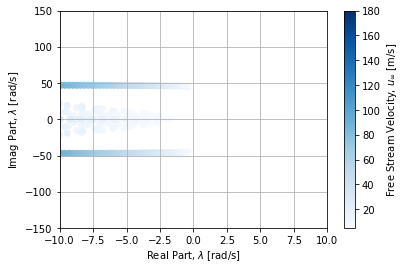

In [25]:
fig = plt.figure()
plt.scatter(eigs_r, eigs_i, c=u_inf, cmap='Blues')
cbar = plt.colorbar()
cbar.set_label('Free Stream Velocity, $u_\infty$ [m/s]')

plt.grid()
plt.xlim(-10, 10)
plt.ylim(-150, 150)
plt.xlabel('Real Part, $\lambda$ [rad/s]')
plt.ylabel('Imag Part, $\lambda$ [rad/s]');

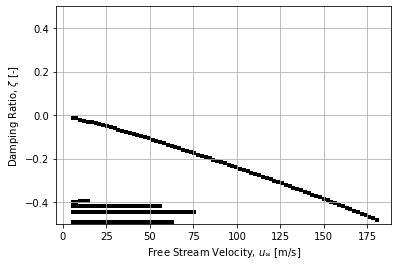

In [34]:
fig = plt.figure()
natural_frequency = np.sqrt(eigs_r ** 2 + eigs_i ** 2)
damping_ratio = eigs_r / natural_frequency
cond = (eigs_r>-40) * (eigs_r<40) * (natural_frequency<100) # filter unwanted eigenvalues for this plot (mostly aero modes)

plt.scatter(u_inf[cond], damping_ratio[cond], color='k', marker='s', s=9)

plt.grid()
plt.ylim(-0.5, 0.5)
plt.xlabel('Free Stream Velocity, $u_\infty$ [m/s]')
plt.ylabel('Damping Ratio, $\zeta$ [-]');

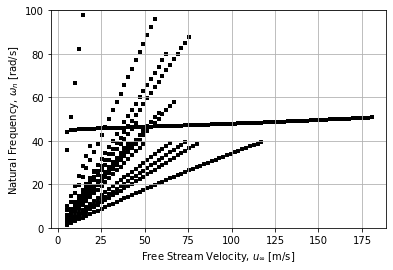

In [31]:
fig = plt.figure()
cond = (eigs_r>-40) * (eigs_r<20) # filter unwanted eigenvalues for this plot (mostly aero modes)
plt.scatter(u_inf[cond], natural_frequency[cond], color='k', marker='s', s=9)

plt.grid()
plt.ylim(0, 100)
plt.xlabel('Free Stream Velocity, $u_\infty$ [m/s]')
plt.ylabel('Natural Frequency, $\omega_n$ [rad/s]');